In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

# Set font before plotting
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2811


In [3]:
# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]


In [4]:
df['누름_record'].unique()

array([nan, '3', '2', '1', '2,3', '1,2', '2+', '1+', '1,3', '2+,3'],
      dtype=object)

In [5]:
# Find rows where '누름_record' contains '1'
contains_1 = df['누름_record'].astype(str).str.contains(r'\b1\b|^1$|^1[+,]', na=False)
indexes_with_1 = df[contains_1].index
indexes_list = indexes_with_1.tolist()
print(indexes_list)

[1021, 1095, 1163, 1167, 1197, 1200, 1214, 1328, 1367, 1399, 1435, 1438, 1520, 1547, 1562, 1563, 1579, 1640, 1719, 1782, 1829, 1830, 1855, 1869, 1936, 1937, 1942, 1957, 1958, 1961, 1985, 2012, 2013, 2020, 2022, 2023, 2025, 2101, 2134, 2151, 2154, 2158, 2161, 2169, 2170, 2176, 2190, 2200, 2210, 2235, 2237, 2245, 2250, 2251, 2253, 2257, 2267, 2269, 2270, 2314, 2320, 2321, 2335, 2338, 2339, 2348, 2370, 2394, 2396, 2398, 2431, 2444, 2446, 2455, 2475, 2479, 2535, 2556, 2566, 2587, 2588, 2596, 2619, 2637, 2638, 2683, 2687, 2694, 2709, 2714, 2722, 2728, 2740, 2741, 2744, 2746, 2765, 2779, 2817, 2822, 2827, 2842, 2848, 2867, 2872, 2877, 2892, 2907, 2908, 2909, 2936]


In [6]:
# Find rows where '누름_record' is exactly or contains '1+'
contains_1_plus = df['누름_record'].astype(str).str.contains(r'\b1\+', na=False)
indexes_with_1_plus = df[contains_1_plus].index
print(indexes_with_1_plus)

Index([1829, 2694, 2714, 2779, 2842], dtype='int64')


In [7]:
# Filter rows where '누름_record' is exactly '1+'
indexes_1_plus = df['누름_record'] == '1+'

# Get the corresponding '날짜' values
dates_for_1_plus = df.loc[indexes_1_plus, '날짜']
print(dates_for_1_plus)

1829    2024-08-26
2694    2024-12-01
2714    2024-12-03
2779    2024-12-10
2842    2024-12-17
Name: 날짜, dtype: object


In [8]:
dates_with_1 = df.loc[indexes_list, '날짜']
for date in dates_with_1:
    print(date)

2024-05-05
2024-05-14
2024-05-22
2024-05-22
2024-05-26
2024-05-26
2024-05-28
2024-06-11
2024-06-17
2024-06-22
2024-06-27
2024-06-27
2024-07-09
2024-07-13
2024-07-15
2024-07-15
2024-07-17
2024-07-27
2024-08-08
2024-08-20
2024-08-26
2024-08-26
2024-09-01
2024-09-02
2024-09-09
2024-09-09
2024-09-10
2024-09-12
2024-09-12
2024-09-12
2024-09-15
2024-09-17
2024-09-17
2024-09-18
2024-09-18
2024-09-18
2024-09-18
2024-09-26
2024-09-29
2024-10-02
2024-10-03
2024-10-03
2024-10-04
2024-10-05
2024-10-05
2024-10-05
2024-10-06
2024-10-07
2024-10-08
2024-10-12
2024-10-12
2024-10-12
2024-10-13
2024-10-13
2024-10-13
2024-10-13
2024-10-14
2024-10-14
2024-10-14
2024-10-20
2024-10-20
2024-10-20
2024-10-21
2024-10-22
2024-10-22
2024-10-23
2024-10-27
2024-10-30
2024-10-30
2024-10-30
2024-11-03
2024-11-04
2024-11-04
2024-11-05
2024-11-08
2024-11-08
2024-11-16
2024-11-17
2024-11-18
2024-11-21
2024-11-21
2024-11-22
2024-11-24
2024-11-25
2024-11-25
2024-11-30
2024-11-30
2024-12-01
2024-12-02
2024-12-03
2024-12-04

In [9]:
dates_with_1.unique()
len(dates_with_1.unique())

72

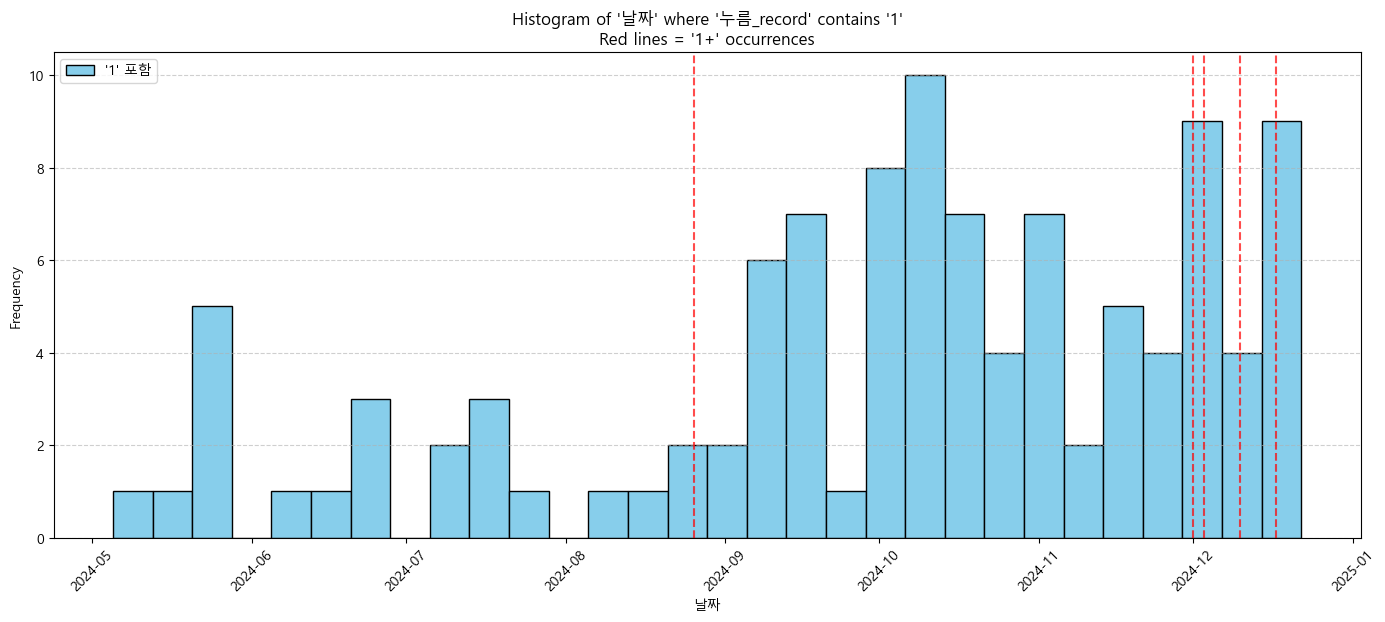

In [10]:
import matplotlib.pyplot as plt

# Make sure 날짜 column is datetime type
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')

# 1. Get index list where '1' appears
contains_1 = df['누름_record'].astype(str).str.contains(r'\b1\b|^1$|^1[+,]', na=False)
indexes_list = df[contains_1].index.tolist()

# 2. Get index list where '1+' appears
contains_1_plus = df['누름_record'].astype(str).str.contains(r'\b1\+', na=False)
indexes_1_plus = df[contains_1_plus].index.tolist()

# 3. Get corresponding 날짜 values
dates_list = df.loc[indexes_list, '날짜']
dates_1_plus = df.loc[indexes_1_plus, '날짜']

# 4. Filter to desired date range
plot_mask = (dates_list >= df.loc[950, '날짜']) & (dates_list <= df.loc[2900, '날짜'])
filtered_dates_list = dates_list[plot_mask]

# 5. Plot histogram with 날짜 on x-axis
plt.figure(figsize=(14, 6))
plt.hist(filtered_dates_list, bins=30, edgecolor='black', color='skyblue', label="'1' 포함")

# 6. Overlay vertical lines for '1+' dates
for date in dates_1_plus:
    if df.loc[950, '날짜'] <= date <= df.loc[2900, '날짜']:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.7)

# 7. Customize plot
plt.title("Histogram of '날짜' where '누름_record' contains '1'\nRed lines = '1+' occurrences")
plt.xlabel("날짜")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
